
# Crypto LSTM with Asset Embeddings (TensorFlow)

This notebook builds a full pipeline to train a stacked LSTM with **asset embeddings** on your wide table of hourly data:
- `time`
- `<ASSET>_price` and `<ASSET>_volume` for each asset (e.g., `BTC_price`, `BTC_volume`, ...)

You can drop your wide DataFrame in as `df_wide` and run end-to-end.

> Generated: 2025-09-03T02:56:41Z


In [233]:

# --- Setup & Config ---
import numpy as np
import pandas as pd
from typing import List, Dict
from pathlib import Path

import json
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, Input, concatenate, Embedding, Reshape, BatchNormalization
import tensorflow.keras.backend as K
from tensorflow.keras.saving import save_model

print("TF version:", tf.__version__)

TF version: 2.18.0


In [234]:
LOOKBACK_L = 48     # lookback window length (hours)
HORIZON_H  = 3      # prediction horizon (hours)
BATCH_TRAIN = 256
BATCH_EVAL  = 512
EPOCHS = 30

ASSUME_TZ = None

FEATURES = ["price_pct_change", "volume_pct_change"]
TARGET   = "target_pct_chage"


## Load your data (`df_wide`) & drop empty assets

Expected format: wide DataFrame with
- `time`
- `<ASSET>_price`, `<ASSET>_volume`

We will **drop any asset** whose `_price` and `_volume` columns are entirely NaN **before** reshaping.
If `df_wide` is not defined, we create a small toy dataset.


In [235]:
df_wide = pd.read_csv("crypto_market_dataset.csv", dtype={"time": "string"})

# Best: ISO8601 parser (handles 'T', fractional seconds, and 'Z')
df_wide["time"] = pd.to_datetime(df_wide["time"], format="ISO8601", utc=True)

# --- Normalize column names: rename *_close -> *_price ---
rename_map = {}
for col in df_wide.columns:
    if col.endswith("_close"):
        asset = col.rsplit("_", 1)[0]   # everything before "_close"
        rename_map[col] = f"{asset}_price"

if rename_map:
    df_wide = df_wide.rename(columns=rename_map)
    print("Renamed columns:", rename_map)

In [236]:
def find_majority_window(df_wide, min_frac=0.8):
    """
    Given df_wide with columns:
        - 'time'
        - <ASSET>_price, <ASSET>_volume
    Returns the largest contiguous [start, end] where
    at least `min_frac` of assets have data at each timestamp.
    """
    df = df_wide.copy()
    df['time'] = pd.to_datetime(df['time'], utc=True)

    # Identify asset prefixes
    assets = sorted({c.split("_")[0] for c in df.columns if c.endswith(("_price","_volume"))})

    # Count how many assets are non-NaN at each timestamp (price only)
    price_cols = [f"{a}_price" for a in assets if f"{a}_price" in df.columns]
    df['available'] = df[price_cols].notna().sum(axis=1)

    # Fraction of available assets at each time
    df['coverage'] = df['available'] / len(price_cols)

    # Mask where coverage >= threshold
    mask = df['coverage'] >= min_frac

    # Find contiguous runs of True
    df['block'] = (mask != mask.shift()).cumsum()
    runs = (
        df.loc[mask]
          .groupby('block')
          .agg(start=('time','min'), end=('time','max'), length=('time','count'))
    )

    if runs.empty:
        raise RuntimeError("No window satisfies coverage threshold.")

    # Pick the longest run
    best = runs.loc[runs['length'].idxmax()]
    return best['start'], best['end'], runs

In [237]:
start, end, runs = find_majority_window(df_wide, min_frac=0.6)
print("Best window:", start, "→", end, f"(length {runs['length'].max()} rows)")

Best window: 2024-03-21 12:00:00+00:00 → 2025-09-03 15:00:00+00:00 (length 12658 rows)


In [238]:
df_cut = df_wide[(df_wide["time"] >= start) & (df_wide["time"] <= end)].copy()

print("Original shape:", df_wide.shape)
print("Trimmed shape:", df_cut.shape)
print("Window:", start, "→", end)

Original shape: (92559, 55)
Trimmed shape: (12658, 55)
Window: 2024-03-21 12:00:00+00:00 → 2025-09-03 15:00:00+00:00


In [239]:
df_test_data = df_wide[(df_wide["time"] < start)].copy()
eth_data = pd.DataFrame()
eth_data["time"] = df_test_data["time"].values
eth_data["ETH_price"] = df_test_data["ETH_price"].values
eth_data["ETH_volume"] = df_test_data["ETH_volume"].values

eth_data.to_csv("./paper_wallet_data/eth_data.csv")

In [240]:
# --- Drop sparse assets (<90% non-NaN in price or volume) ---
threshold = 0.9
n_rows = len(df_cut)

asset_prefixes = {c.split("_")[0] for c in df_cut.columns if "_" in c and c != "time"}
drop_cols = []
dropped_assets = []

for a in sorted(asset_prefixes):
    p, v = f"{a}_price", f"{a}_volume"
    if p in df_cut.columns and v in df_cut.columns:
        frac_price  = df_cut[p].notna().mean()
        frac_volume = df_cut[v].notna().mean()
        if (frac_price < threshold) or (frac_volume < threshold):
            drop_cols += [p, v]
            dropped_assets.append((a, frac_price, frac_volume))

if drop_cols:
    df_cut = df_cut.drop(columns=drop_cols)
    print("Dropped sparse assets (name, price%, volume%):")
    for a, fp, fv in dropped_assets:
        print(f"  {a:6s}  price={fp:.2%}, volume={fv:.2%}")

remaining_assets = sorted({c.split("_")[0] for c in df_cut.columns if "_" in c and c != "time"})
print("Remaining assets:", remaining_assets[:10], "... (total:", len(remaining_assets), ")")


Dropped sparse assets (name, price%, volume%):
  ENA     price=17.03%, volume=17.03%
  HYPE    price=13.26%, volume=13.26%
  MNT     price=63.79%, volume=63.79%
  PEPE    price=55.71%, volume=55.71%
  TAO     price=36.63%, volume=36.63%
  TON     price=61.28%, volume=61.28%
  WLFI    price=0.40%, volume=0.40%
Remaining assets: ['AAVE', 'ADA', 'AVAX', 'BCH', 'BTC', 'DOGE', 'DOT', 'ETC', 'ETH', 'HBAR'] ... (total: 20 )



## Reshape wide → long & hourly reindex


In [241]:
df = df_cut.copy()
df['time'] = pd.to_datetime(df['time'], utc=True)
if ASSUME_TZ is not None:
    df['time'] = df['time'].dt.tz_convert('UTC')

assets = sorted({c.split("_")[0] for c in df.columns if c.endswith(("_price","_volume"))})

# Keep only price/volume pairs that actually exist
pairs = []
for a in assets:
    p, v = f"{a}_price", f"{a}_volume"
    if p in df.columns and v in df.columns:
        pairs.append((a, "price"))
        pairs.append((a, "volume"))
keep_cols = ["time"] + [f"{a}_price" for a in assets if f"{a}_price" in df.columns] + [f"{a}_volume" for a in assets if f"{a}_volume" in df.columns]
df = df[keep_cols]

# Build MultiIndex columns (asset, field)
mi_cols = [("__meta__","time")] + [(a,"price") for a in assets if f"{a}_price" in df.columns] + [(a,"volume") for a in assets if f"{a}_volume" in df.columns]
df.columns = pd.MultiIndex.from_tuples(mi_cols)

# To long panel
df = df.set_index(("__meta__","time"))
df.columns.names = ["asset","field"]
long = df.stack("asset").reset_index().rename(columns={("__meta__","time"): "time"})
long = long[["time","asset","price","volume"]].sort_values(["asset","time"]).reset_index(drop=True)

# Hourly reindex & light fill
def reindex_hourly(g):
    g = g.set_index("time").asfreq("1H")
    # Guard against non-positive price before log (set to NaN so it gets dropped later)
    g.loc[g["price"] <= 0, "price"] = np.nan
    g["price"]  = g["price"].ffill()
    g["volume"] = g["volume"].fillna(0.0)
    return g.reset_index()

long = long.groupby("asset", group_keys=False).apply(reindex_hourly)
print("Long shape after reindex:", long.shape)
long.head()

Long shape after reindex: (254958, 4)


/var/folders/1f/5lhk7sb97rz53v7gk1vkcjkr0000gn/T/ipykernel_1054/1418215485.py:25: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  long = df.stack("asset").reset_index().rename(columns={("__meta__","time"): "time"})
/var/folders/1f/5lhk7sb97rz53v7gk1vkcjkr0000gn/T/ipykernel_1054/1418215485.py:30: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  g = g.set_index("time").asfreq("1H")
/var/folders/1f/5lhk7sb97rz53v7gk1vkcjkr0000gn/T/ipykernel_1054/1418215485.py:30: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  g = g.set_index("time").asfreq("1H")
/var/folders/1f/5lhk7sb97rz53v7gk1vkcjkr0000gn/T/ipykernel_1054/1418215485.py:30: FutureWarning: 'H' is deprecated and will be removed in

field,time,asset,price,volume
0,2024-03-21 13:00:00+00:00,AAVE,120.29,119.004
1,2024-03-21 14:00:00+00:00,NaN,120.29,0.000
2,2024-03-21 15:00:00+00:00,AAVE,120.29,1355.469
3,2024-03-21 16:00:00+00:00,AAVE,123.01,4274.835
4,2024-03-21 17:00:00+00:00,AAVE,122.06,7042.400



## Feature engineering & label (with NaN cleanup)


In [242]:

# Log price & label
long["log_price"] = np.log(long["price"])
long["y_ret_h"] = long.groupby("asset")["log_price"].shift(-HORIZON_H) - long["log_price"]

# make sure there are no duplicate (asset, time) rows and the order is stable
long = long.sort_values(["asset","time"]).drop_duplicates(["asset","time"]).reset_index(drop=True)

# returns
long["ret_1h"]  = long.groupby("asset")["log_price"].diff(1)
long["ret_6h"]  = long.groupby("asset")["log_price"].diff(6)
long["ret_24h"] = long.groupby("asset")["log_price"].diff(24)

# rolling realized volatility over 24 *rows* per asset
long["rv_24h"] = (
    long.groupby("asset")["ret_1h"]
        .transform(lambda s: s.rolling(window=24, min_periods=24).std())
)

# Volume transform
long["log_vol"] = np.log1p(long["volume"])

# Calendar
long["hour"] = long["time"].dt.hour
long["dow"]  = long["time"].dt.dayofweek
long["hour_sin"] = np.sin(2*np.pi*long["hour"]/24)
long["hour_cos"] = np.cos(2*np.pi*long["hour"]/24)
long["dow_sin"]  = np.sin(2*np.pi*long["dow"]/7)
long["dow_cos"]  = np.cos(2*np.pi*long["dow"]/7)

long["price_pct_change"] = long['price'].pct_change(1)   
long["volume_pct_change"] = long['volume'].pct_change(1)
long["target_pct_chage"] = long['price'].pct_change(HORIZON_H)

# --- Drop rows that cannot be used (NaNs from diffs/rolling/label shift) ---
before = len(long)
long = long.dropna().reset_index(drop=True)
after = len(long)
print(f"Dropped {before-after} rows with NaNs across FEATURES+TARGET")

long.head()


Dropped 664 rows with NaNs across FEATURES+TARGET


field,time,asset,price,volume,log_price,y_ret_h,ret_1h,ret_6h,ret_24h,rv_24h,log_vol,hour,dow,hour_sin,hour_cos,dow_sin,dow_cos,price_pct_change,volume_pct_change,target_pct_chage
0,2024-03-22 14:00:00+00:00,AAVE,115.25,6557.805,4.747104,0.018909,-0.008295,-0.061334,-0.042802,0.014545,8.788564,14,4,-0.500000,-8.660254e-01,-0.433884,-0.900969,-0.008261,0.920270,-0.029310
1,2024-03-22 15:00:00+00:00,AAVE,117.76,3082.261,4.768649,-0.002806,0.021545,-0.036683,-0.021257,0.015305,8.033743,15,4,-0.707107,-7.071068e-01,-0.433884,-0.900969,0.021779,-0.529986,-0.011915
2,2024-03-22 16:00:00+00:00,AAVE,116.67,1719.785,4.759349,0.009469,-0.009299,-0.021537,-0.052916,0.014560,7.450536,16,4,-0.866025,-5.000000e-01,-0.433884,-0.900969,-0.009256,-0.442038,0.003958
3,2024-03-22 17:00:00+00:00,AAVE,117.45,2266.151,4.766013,-0.005721,0.006663,-0.010839,-0.038500,0.014619,7.726279,17,4,-0.965926,-2.588190e-01,-0.433884,-0.900969,0.006686,0.317694,0.019089
4,2024-03-22 18:00:00+00:00,AAVE,117.43,893.595,4.765842,-0.010874,-0.000170,-0.014793,-0.008649,0.013307,6.796371,18,4,-1.000000,-1.836970e-16,-0.433884,-0.900969,-0.000170,-0.605677,-0.002802



## Train / Validation / Test split by time


In [243]:

t1 = long["time"].quantile(0.70)
t2 = long["time"].quantile(0.85)
train = long[long["time"] < t1].copy()
val   = long[(long["time"] >= t1) & (long["time"] < t2)].copy()
test  = long[long["time"] >= t2].copy()
print("Split sizes:", len(train), len(val), len(test))


Split sizes: 176796 37880 37900



## Per-asset scaling on train-only stats


In [244]:

def fit_asset_stats(g):
    stats = {}
    for col in ["log_vol","rv_24h"]:
        s = g[col].dropna()
        mu = float(s.mean()) if len(s) else 0.0
        sd = float(s.std(ddof=0)) if len(s) and s.std(ddof=0) != 0 else 1.0
        stats[col] = {"mean": mu, "std": sd}
    return stats

asset_stats: Dict[str, Dict[str, Dict[str, float]]] = {a: fit_asset_stats(g) for a, g in train.groupby("asset")}

def apply_asset_stats(df_):
    out = df_.copy()
    for a, g in out.groupby("asset"):
        st = asset_stats.get(a, {})
        for col in ["log_vol","rv_24h"]:
            if col in g:
                mu = st.get(col, {}).get("mean", 0.0)
                sd = st.get(col, {}).get("std", 1.0)
                out.loc[g.index, col] = (g[col] - mu) / sd
    return out

train = apply_asset_stats(train)
val   = apply_asset_stats(val)
test  = apply_asset_stats(test)

train.head()


field,time,asset,price,volume,log_price,y_ret_h,ret_1h,ret_6h,ret_24h,rv_24h,log_vol,hour,dow,hour_sin,hour_cos,dow_sin,dow_cos,price_pct_change,volume_pct_change,target_pct_chage
0,2024-03-22 14:00:00+00:00,AAVE,115.25,6557.805,4.747104,0.018909,-0.008295,-0.061334,-0.042802,0.784371,1.366951,14,4,-0.500000,-8.660254e-01,-0.433884,-0.900969,-0.008261,0.920270,-0.029310
1,2024-03-22 15:00:00+00:00,AAVE,117.76,3082.261,4.768649,-0.002806,0.021545,-0.036683,-0.021257,0.934188,0.675502,15,4,-0.707107,-7.071068e-01,-0.433884,-0.900969,0.021779,-0.529986,-0.011915
2,2024-03-22 16:00:00+00:00,AAVE,116.67,1719.785,4.759349,0.009469,-0.009299,-0.021537,-0.052916,0.787419,0.141258,16,4,-0.866025,-5.000000e-01,-0.433884,-0.900969,-0.009256,-0.442038,0.003958
3,2024-03-22 17:00:00+00:00,AAVE,117.45,2266.151,4.766013,-0.005721,0.006663,-0.010839,-0.038500,0.798935,0.393851,17,4,-0.965926,-2.588190e-01,-0.433884,-0.900969,0.006686,0.317694,0.019089
4,2024-03-22 18:00:00+00:00,AAVE,117.43,893.595,4.765842,-0.010874,-0.000170,-0.014793,-0.008649,0.540280,-0.457986,18,4,-1.000000,-1.836970e-16,-0.433884,-0.900969,-0.000170,-0.605677,-0.002802



## Windowing to sequences & asset embeddings


In [245]:
asset_to_id = {a:i for i,a in enumerate(sorted(train["asset"].unique()))}
n_assets = len(asset_to_id)
feat_dim = len(FEATURES)
print("Assets:", n_assets, asset_to_id)

def make_sequences(df, L):
    X_list, A_list, y_list = [], [], []
    for a, g in df.groupby("asset"):
        g = g.sort_values("time")
        X = g[FEATURES].values
        A = np.full(len(g), asset_to_id[a], dtype=np.int64)
        y = g[TARGET].values
        for t in range(L, len(g)):
            X_list.append(X[t-L:t,:])
            A_list.append(A[t])
            y_list.append(y[t])
    return np.stack(X_list), np.array(A_list), np.array(y_list)

X_tr,A_tr,y_tr = make_sequences(train, LOOKBACK_L)
X_va,A_va,y_va = make_sequences(val, LOOKBACK_L)
X_te,A_te,y_te = make_sequences(test, LOOKBACK_L)
print("Sequence shapes:", X_tr.shape, X_va.shape, X_te.shape)

Assets: 20 {'AAVE': 0, 'ADA': 1, 'AVAX': 2, 'BCH': 3, 'BTC': 4, 'DOGE': 5, 'DOT': 6, 'ETC': 7, 'ETH': 8, 'HBAR': 9, 'LINK': 10, 'LTC': 11, 'SHIB': 12, 'SOL': 13, 'SUI': 14, 'TRX': 15, 'UNI': 16, 'XLM': 17, 'XMR': 18, 'XRP': 19}
Sequence shapes: (175836, 48, 2) (36920, 48, 2) (36940, 48, 2)


In [246]:
#save assets json, to ensure we have the right id later
with open("paper_wallet_data/asset_to_id.json", "w") as f:
    json.dump(asset_to_id, f)


## Build `tf.data` datasets


In [247]:

def make_ds(X,A,y,batch=256,shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices(({"seq":X,"asset_id":A},y))
    if shuffle: ds = ds.shuffle(min(len(X),100000), reshuffle_each_iteration=True)
    return ds.batch(batch).prefetch(tf.data.AUTOTUNE)

train_ds = make_ds(X_tr,A_tr,y_tr,batch=256,shuffle=True)
val_ds   = make_ds(X_va,A_va,y_va,batch=512,shuffle=False)
test_ds  = make_ds(X_te,A_te,y_te,batch=512,shuffle=False)
for sample in train_ds.take(1):
    print({k: v.shape for k,v in sample[0].items()}, "->", sample[1].shape)


{'seq': TensorShape([256, 48, 2]), 'asset_id': TensorShape([256])} -> (256,)



## Model: Asset Embedding + Stacked LSTM (Keras)


In [248]:
n_features = len(FEATURES)

returns = Input(shape=(LOOKBACK_L, n_features), name='Returns')
tickers = Input(shape=(1,), name='Tickers')

In [249]:
lstm1_units = 25
lstm2_units = 10

In [250]:
lstm1 = LSTM(units=lstm1_units, 
             input_shape=(LOOKBACK_L, 
                          n_features), 
             name='LSTM1', 
             dropout=.2,
             return_sequences=True)(returns)

lstm_model = LSTM(units=lstm2_units, 
             dropout=.2,
             name='LSTM2')(lstm1)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [251]:
ticker_embedding = Embedding(input_dim=n_assets, 
                             output_dim=5, 
                             input_length=1)(tickers)
ticker_embedding = Reshape(target_shape=(5,))(ticker_embedding)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [252]:
merged = concatenate([lstm_model, 
                      ticker_embedding], name='Merged')

bn = BatchNormalization()(merged)
hidden_dense = Dense(10, name='FC1')(bn)

output = Dense(1, name='Output')(hidden_dense)

rnn = Model(inputs=[returns, tickers], outputs=output)

In [253]:
rnn.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Returns             │ (None, 48, 2)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Tickers             │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ LSTM1 (LSTM)        │ (None, 48, 25)    │      2,800 │ Returns[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_8         │ (None, 1, 5)      │        100 │ Tickers[0][0]     │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ LSTM2 (LSTM)        │ (None, 10)        │      1,440 │ LSTM1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_8 (Reshape) │ (None, 5)         │          0 │ embedding_8[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Merged              │ (None, 15)        │          0 │ LSTM2[0][0],      │
│ (Concatenate)       │                   │            │ reshape_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 15)        │         60 │ Merged[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ FC1 (Dense)         │ (None, 10)        │        160 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Output (Dense)      │ (None, 1)         │         11 │ FC1[0][0]         │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,571 (17.86 KB)

 Trainable params: 4,541 (17.74 KB)

 Non-trainable params: 30 (120.00 B)


## Train


In [254]:
optimizer =tf.keras.optimizers.Adam()

rnn.compile(loss='mse',
            optimizer=optimizer)

In [255]:
results_path = Path('results', 'models')
if not results_path.exists():
    results_path.mkdir(parents=True)
    
lstm_path = (results_path / 'lstm.regression.keras').as_posix()

checkpointer = ModelCheckpoint(filepath=lstm_path,
                               verbose=1,
                               monitor='val_loss',
                               mode='min',
                               save_best_only=True)

In [256]:
early_stopping = EarlyStopping(monitor='val_loss', 
                              patience=5,
                              restore_best_weights=True)

In [257]:
X_tr.shape

(175836, 48, 2)

In [258]:
training = rnn.fit([X_tr, A_tr],
                   y_tr,
                   epochs=50,
                   batch_size=64,
                    validation_data=([X_te, A_te], y_te),  # ✅ both inputs here
                   callbacks=[early_stopping, checkpointer],
                   verbose=1)

Epoch 1/50
2745/2748 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0450
Epoch 1: val_loss improved from inf to 0.00043, saving model to results/models/lstm.regression.keras
2748/2748 ━━━━━━━━━━━━━━━━━━━━ 38s 13ms/step - loss: 0.0449 - val_loss: 4.3106e-04
Epoch 2/50
2748/2748 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.0557e-04
Epoch 2: val_loss did not improve from 0.00043
2748/2748 ━━━━━━━━━━━━━━━━━━━━ 35s 13ms/step - loss: 5.0557e-04 - val_loss: 4.3264e-04
Epoch 3/50
2746/2748 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.2812e-04
Epoch 3: val_loss improved from 0.00043 to 0.00020, saving model to results/models/lstm.regression.keras
2748/2748 ━━━━━━━━━━━━━━━━━━━━ 35s 13ms/step - loss: 3.2807e-04 - val_loss: 2.0319e-04
Epoch 4/50
2748/2748 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.3039e-04
Epoch 4: val_loss improved from 0.00020 to 0.00017, saving model to results/models/lstm.regression.keras
2748/2748 ━━━━━━━━━━━━━━━━━━━━ 35s 13ms/step - loss: 2.3039e-04 - val_loss: 1.6909e-04
Epoch 


## Evaluate


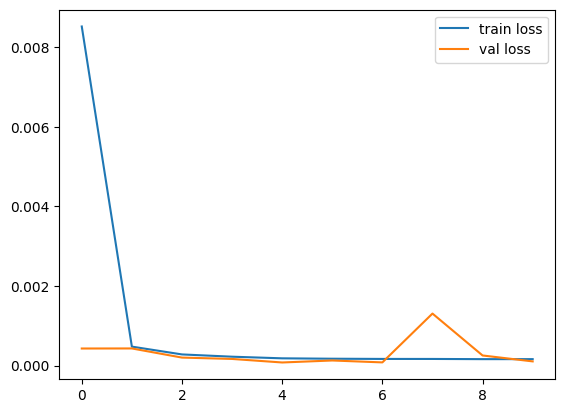

In [259]:
plt.plot(training.history['loss'], label='train loss')
plt.plot(training.history['val_loss'], label='val loss')
plt.legend()
plt.show()

In [260]:
val_metrics = rnn.evaluate({"Returns": X_va, "Tickers": A_va}, y_va,verbose=0)
test_metrics = rnn.evaluate({"Returns": X_te, "Tickers": A_te}, y_te, verbose=0)
print(f"val_metrics: {val_metrics} test_metrics: {test_metrics}")

val_metrics: 9.056848648469895e-05 test_metrics: 8.032213372644037e-05
